# Validate LLM annotations

The code in this file was copied from https://github.com/nitaytech/AltTest/blob/main/alt_test_example.ipynb, with a few modifications.

Changes made to original method:

- Added new scoring functions: `simple_jaccard_similarity`, `jaccard_similarity`, `hamming_similarity` for multi-label annotations as `accuracy`(exact match) may be too harsh
- Added `multiplicative epsilon`
- Added human advantage probability alongside the original LLM advantage probability
- Saved additional data for advantage probability for further analysis

Tested on an N=50 sample taken from an internal dataset (filenames: `dataset_hand_labelled.csv`, `dataset_llm_labelled.csv`)


### Import libraries


In [1]:
from collections import defaultdict
import json
import os
from typing import List, Dict, Any, Callable, Union
import colorsys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
from sklearn.metrics import jaccard_score, hamming_loss


# Set config for plots
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Verdana"]

## Process data

### Functions to format data into annotations


In [2]:
CATEGORIES = {
    "hateful": ["level_1_discriminatory", "level_2_hate_speech"],
    "insults": ["insults"],
    "sexual": [
        "level_1_not_appropriate_for_minors",
        "level_2_not_appropriate_for_all_ages",
    ],
    "physical_violence": ["physical_violence"],
    "self_harm": ["level_1_self_harm_intent", "level_2_self_harm_action"],
    "all_other_misconduct": [
        "level_1_not_socially_accepted",
        "level_2_illegal_activities",
    ],
}

LLM_NAMES = [
    "o3_mini_high",
    "o3_mini_medium",
    "o3_mini_low",
    "gemini_2_flash",
    "haiku_3.5",
    "llama_3.3_70b",
    "mistral_small_2501",
    "nova_lite",
]

In [3]:
def format_one(df, keep_false=True, explode_levels=False):
    results = {}
    records = df.to_dict("records")
    for record in records:
        prompt_id = record["prompt_id"]
        results[prompt_id] = []

        # Check each category and add to list if TRUE or starts with 'level_'
        for category in CATEGORIES.keys():
            value = record[category]
            if explode_levels:
                for level in CATEGORIES[category]:
                    if value != "FALSE" and value == level:
                        results[prompt_id].append(value)
                    elif keep_false:
                        results[prompt_id].append("FALSE")

            else:
                if value != "FALSE":
                    results[prompt_id].append(
                        category
                    )  # keep only main levels, if sub levels change category to value
                elif keep_false:
                    results[prompt_id].append("FALSE")

    return results

### Load, process and format data

In [4]:
# Read LLM labelled data
df_llm = pd.read_csv(f"dataset_llm_labelled.csv")

# Create annotations for each LLM
llm_annotations = {}
for llm in LLM_NAMES:
    # Extract columns for the current LLM, and remove LLM prefixes
    columns = [col for col in df_llm.columns if col.startswith(llm)]
    df_tmp = df_llm[["prompt_id"] + columns]
    df_tmp.columns = [col.replace(f"{llm}_", "") for col in df_tmp.columns]

    # Format the data into annotations
    llm_annotations[llm] = format_one(df_tmp, keep_false=True, explode_levels=False)

    print(llm, "-", len(llm_annotations[llm]))

o3_mini_high - 50
o3_mini_medium - 50
o3_mini_low - 50
gemini_2_flash - 50
haiku_3.5 - 50
llama_3.3_70b - 50
mistral_small_2501 - 50
nova_lite - 50


In [5]:
# Read hand labelled data
df_human = pd.read_csv(f"dataset_hand_labelled.csv")

# Split annotations by human
human_annotations = {}
for human in df_human["labeller"].unique():
    # Format the data into annotations
    human_annotations[human] = format_one(
        df_human[df_human["labeller"] == human], keep_false=True, explode_levels=False
    )

    print(human, "-", len(human_annotations[human]))

H1 - 50
H2 - 50
H3 - 50
H4 - 50
H5 - 50
H6 - 50


## Run Alt-Test

### Functions to run Alt-Test

In [6]:
def open_json(file_path: str) -> Dict:
    with open(file_path, "r") as f:
        return json.load(f)


def by_procedure(p_values: List[float], q: float) -> List[int]:
    p_values = np.array(p_values, dtype=float)
    m = len(p_values)
    sorted_indices = np.argsort(p_values)
    sorted_pvals = p_values[sorted_indices]
    # Compute the harmonic sum H_m = 1 + 1/2 + ... + 1/m
    H_m = np.sum(1.0 / np.arange(1, m + 1))
    # Compute the BY thresholds for each rank i
    by_thresholds = (np.arange(1, m + 1) / m) * (q / H_m)
    max_i = -1
    for i in range(m):
        if sorted_pvals[i] <= by_thresholds[i]:
            max_i = i
    if max_i == -1:
        return []
    rejected_sorted_indices = sorted_indices[: max_i + 1]
    return list(rejected_sorted_indices)


# In the case of multi-label annotations, this function uses exact match of every label.
def accuracy(pred: Any, annotations: List[Any]) -> float:
    return float(np.mean([pred == ann for ann in annotations]))


def neg_rmse(pred: Union[int, float], annotations: List[Union[int, float]]) -> float:
    return -1 * float(np.sqrt(np.mean([(pred - ann) ** 2 for ann in annotations])))


##### Modification: additional scoring functions #####


# Simple set-based jaccard similarity
def simple_jaccard_similarity(pred: List[str], annotations: List[List[str]]) -> float:
    jaccard_scores = []
    for ann in annotations:
        # If both are empty, return 1.0
        if not pred and not ann:
            jaccard_scores.append(1.0)
            continue

        intersection = len(set(pred) & set(ann))
        union = len(set(pred) | set(ann))
        jaccard_scores.append(intersection / union)
    return float(np.mean(jaccard_scores))


# Macro-averaged jaccard similarity
def jaccard_similarity(pred: List[str], annotations: List[List[str]]) -> float:
    jaccard_scores = []
    for ann in annotations:
        jaccard_scores.append(jaccard_score(y_true=ann, y_pred=pred, average="macro"))

    return float(np.mean(jaccard_scores))


# Hamming similarity
def hamming_similarity(pred: List[str], annotations: List[List[str]]) -> float:
    hamming_scores = []
    for ann in annotations:
        hamming_scores.append(1 - hamming_loss(y_true=ann, y_pred=pred))

    return float(np.mean(hamming_scores))


####################


def sim(pred: str, annotations: List[str], similarity_func: Callable) -> float:
    return float(np.mean([similarity_func(pred, ann) for ann in annotations]))


def ttest(indicators, epsilon: float) -> float:
    return ttest_1samp(indicators, epsilon, alternative="less").pvalue


def alt_test(
    llm_annotations: Dict[Union[int, str], Any],
    humans_annotations: Dict[Union[int, str], Dict[Union[int, str], Any]],
    scoring_function: Union[str, Callable] = "accuracy",
    epsilon: float = 0.2,
    multiplicative_epsilon: bool = False,
    q_fdr: float = 0.05,
    min_humans_per_instance: int = 2,
    min_instances_per_human: int = 30,
):
    # Modification: prepare alignment scoring function
    if isinstance(scoring_function, str):
        if scoring_function == "accuracy":
            scoring_function = accuracy
        elif scoring_function == "neg_rmse":
            scoring_function = neg_rmse
        elif scoring_function == "simple_jaccard_similarity":
            scoring_function = simple_jaccard_similarity
        elif scoring_function == "jaccard_similarity":
            scoring_function = jaccard_similarity
        elif scoring_function == "hamming_similarity":
            scoring_function = hamming_similarity
        else:
            raise ValueError("Unknown scoring function")
    else:
        scoring_function = scoring_function

    # prepare sets - i_set has humans as keys, h_set has instances as keys
    i_set, h_set = {}, {}
    for h, anns in humans_annotations.items():
        i_set[h] = list(anns.keys())
        for i, ann in anns.items():
            if i not in h_set:
                h_set[i] = []
            h_set[i].append(h)

    # remove instances with less than min_humans_per_instance
    instances_to_keep = {
        i
        for i in h_set
        if len(h_set[i]) >= min_humans_per_instance and i in llm_annotations
    }
    i_set = {h: [i for i in i_set[h] if i in instances_to_keep] for h in i_set}
    h_set = {i: h_set[i] for i in h_set if i in instances_to_keep}

    ## Save llm vs human advantage probability
    human_advantage_probs = {}

    p_values, advantage_probs, humans = [], [], []
    for excluded_h in humans_annotations:
        llm_indicators = []
        excluded_indicators = []
        instances = [i for i in i_set[excluded_h] if i in llm_annotations]
        if len(instances) < min_instances_per_human:
            print(
                f"Skipping annotator {excluded_h} with only {len(instances)} instances < {min_instances_per_human}."
            )
            continue

        for i in instances:
            human_ann = humans_annotations[excluded_h][i]
            llm_ann = llm_annotations[i]
            remaining_anns = [
                humans_annotations[h][i] for h in h_set[i] if h != excluded_h
            ]
            human_score = scoring_function(human_ann, remaining_anns)
            llm_score = scoring_function(llm_ann, remaining_anns)
            llm_indicators.append(1 if llm_score >= human_score else 0)
            excluded_indicators.append(1 if human_score >= llm_score else 0)

        # Modification: Calculate p-value based on epsilon type
        if multiplicative_epsilon:
            diff_indicators = [
                exc_ind - (llm_ind / (1 - epsilon))
                for exc_ind, llm_ind in zip(excluded_indicators, llm_indicators)
            ]
            p = ttest(diff_indicators, 0)
        else:
            diff_indicators = [
                exc_ind - llm_ind
                for exc_ind, llm_ind in zip(excluded_indicators, llm_indicators)
            ]
            p = ttest(diff_indicators, epsilon)

        p_values.append(p)

        advantage_probs.append(float(np.mean(llm_indicators)))
        humans.append(excluded_h)

        # Save human advantage probability
        human_advantage_probs[excluded_h] = (
            float(np.mean(llm_indicators)),
            float(np.mean(excluded_indicators)),
        )

    rejected_indices = by_procedure(p_values, q_fdr)
    advantage_prob = float(np.mean(advantage_probs))
    winning_rate = len(rejected_indices) / len(humans)
    return winning_rate, advantage_prob, human_advantage_probs

In [7]:
def get_results(
    llm_annotations, human_annotations, metrics, epsilons, multiplicative_epsilon=False
):
    results = defaultdict(list)
    ap_results = defaultdict(list)

    for metric in metrics:
        print(f"***** {metric} *****")
        for llm_name, annotations in llm_annotations.items():
            for epsilon in epsilons:
                wr, ap, human_ap = alt_test(
                    annotations,
                    human_annotations,
                    metric,
                    epsilon=epsilon,
                    multiplicative_epsilon=multiplicative_epsilon,
                )
                # print(
                #     f"{llm_name} [{'PASSED' if wr >= 0.5 else 'FAILED'}]:\tWinning Rate={wr:.2f}\tAdvantage Probability={ap:.2f}"
                # )

                # Save alt-test results
                results["metric"].append(metric)
                results["epsilon"].append(epsilon)
                results["llm"].append(llm_name)
                results["wr"].append(wr)
                results["ap"].append(ap)

            # Save advantage probabilties (epsilon doesn't affect AP, so we can just save the last one)
            ap_results["metric"].append(metric)
            ap_results["llm"].append(llm_name)
            for k, v in human_ap.items():
                ap_results[k].append(v)

    return results, ap_results

### Functions to plot results

In [8]:
def generate_colors(n):
    """
    Generate a set of standardised colors for n models.
    """
    # Start with hues that avoid green/yellow (in HSV, green is around 0.33 and yellow is around 0.17)
    hues = np.linspace(0.7, 1.0, n // 2)
    hues = np.append(hues, np.linspace(0.0, 0.1, n - len(hues)))  # Add reds

    colors = []
    # Define base hues avoiding green/yellow (0.2-0.4)
    base_hues = [
        0.0,  # Red
        0.1,  # Orange
        0.6,  # Blue
        0.8,  # Purple
        0.5,  # Blue-Cyan
        0.7,  # Blue-Purple
        0.9,  # Pink-Red
    ]

    # Create more variations based on n
    for i in range(n):
        hue = base_hues[i % len(base_hues)]
        # Vary saturation and value based on which pass through base_hues we're on
        saturation = 0.8 - (i // len(base_hues)) * 0.8  # Decrease saturation each pass
        value = 0.9 - (i // len(base_hues)) * 0.2  # Decrease value each pass

        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        hex_color = "#%02x%02x%02x" % tuple(int(x * 255) for x in rgb)
        colors.append(hex_color)

    return colors


# Plot winning rate
def plot_wr(results, models):
    """
    Plot the winning rate for each model across different metrics and epsilons.
    """
    df = pd.DataFrame(results)
    colors = generate_colors(len(models))
    metrics = df["metric"].unique()

    # Create the plot
    plt.figure(figsize=(12, 8))
    legend_handles = []

    for idx, metric in enumerate(metrics):
        plt.subplot(2, 2, idx + 1)
        epsilons = df["epsilon"].unique()

        # Highlight pass/fail regions
        plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
        plt.fill_between(
            epsilons, 0.5, 1.0, color="lightgreen", alpha=0.15, label="PASS"
        )
        plt.fill_between(epsilons, 0, 0.5, color="mistyrose", alpha=0.15, label="FAIL")

        # Plot each model's winning rate
        for i, model in enumerate(models):
            model_data = df[(df["llm"] == model) & (df["metric"] == metric)]
            ap = model_data["ap"].iloc[0]
            [line] = plt.plot(
                model_data["epsilon"],
                model_data["wr"],
                marker="o",
                color=colors[i],
                label=f"{model} (AP={ap:.2f})",
            )
            if idx == 0:
                legend_handles.append(line)

        plt.title(f"{metric}")
        plt.xlabel("Epsilon")
        plt.ylabel("Winning Rate")
        plt.grid(True)

    # Single legend for all subplots
    plt.figlegend(
        handles=legend_handles,
        labels=[
            f'{model} (AP={df[(df["llm"] == model) & (df["metric"] == metrics[0])]["ap"].iloc[0]:.2f})'
            for model in models
        ],
        bbox_to_anchor=(1.02, 0.5),
        loc="center left",
    )
    plt.tight_layout()
    return plt.gcf()


RENAME_METRICS = {
    "accuracy": "Accuracy",
    "simple_jaccard_similarity": "Simple Jaccard Similarity",
    "jaccard_similarity": "Macro Jaccard Similarity",
    "hamming_similarity": "Hamming Similarity",
}


# Plot advantage probability
def plot_ap(results, models):
    """
    Plot the advantage probability for each model across different metrics.
    """
    df = pd.DataFrame(results)
    colors = generate_colors(len(models))
    metrics = df["metric"].unique()

    plt.figure(figsize=(12, 6))
    legend_handles = []

    for idx, metric in enumerate(metrics):
        plt.subplot(2, 2, idx + 1)
        # Plot a bar for each model
        for i, model in enumerate(models):
            model_data = df[(df["llm"] == model) & (df["metric"] == metric)]
            [bar] = plt.bar(
                i,
                model_data["ap"].iloc[0],
                color=colors[i],
                width=0.75,
                label=f"{model}",
            )
            if idx == 0:
                legend_handles.append(bar)

        plt.title(f"{RENAME_METRICS.get(metric, metric)}", pad=20, loc="left")
        plt.ylabel("Advantage Probability")
        plt.grid(True, alpha=0.3)

    plt.figlegend(
        handles=legend_handles,
        labels=models,
        bbox_to_anchor=(1.02, 0.5),
        loc="center left",
    )
    plt.tight_layout()
    return plt.gcf()


def save_plot(fig, save_path):
    """
    Save a matplotlib figure.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save with high quality settings
    fig.savefig(
        save_path, dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none"
    )
    print(f"Saved plot to {save_path}")

### Run validation with alt-test


In [9]:
metrics = [
    "accuracy",
    "simple_jaccard_similarity",
    "jaccard_similarity",
    "hamming_similarity",
]
epsilons = np.arange(
    0, 0.31, 0.05
)  # ε is a param to adjust the cost of the human annotations. it lowers the threshold the LLM must exceed.
results, ap_results = get_results(
    llm_annotations, human_annotations, metrics, epsilons, multiplicative_epsilon=True
)

***** accuracy *****
***** simple_jaccard_similarity *****
***** jaccard_similarity *****
***** hamming_similarity *****


### Analyse: Which model is a better alternative to human annotators?


Saved plot to ./llm_winning_rates.png


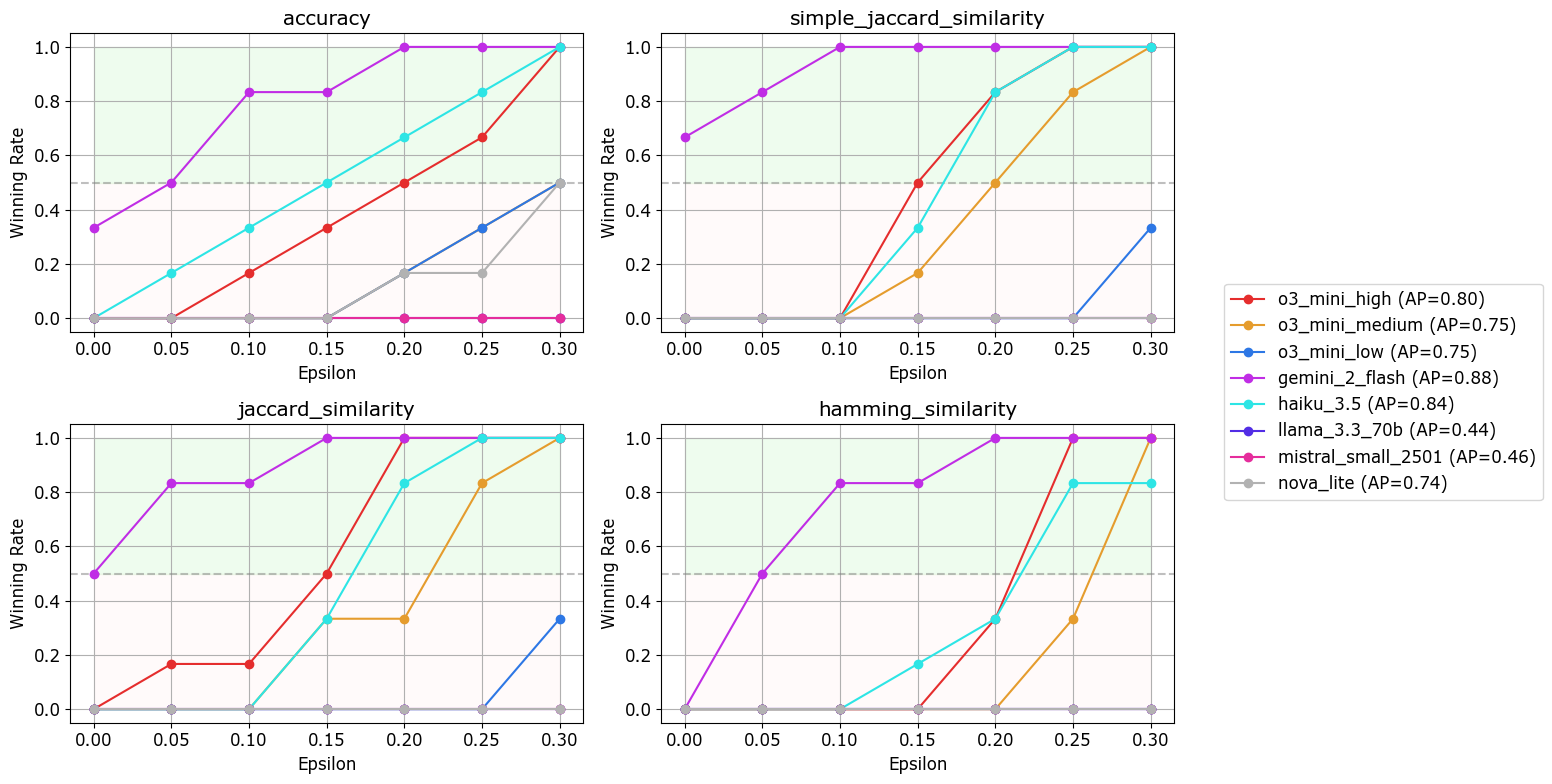

In [10]:
fig = plot_wr(results, LLM_NAMES)
save_plot(fig, f"./llm_winning_rates.png")

### Analyse: Which model has better agreement with humans?

Saved plot to ./llm_advantage_probabilities.png


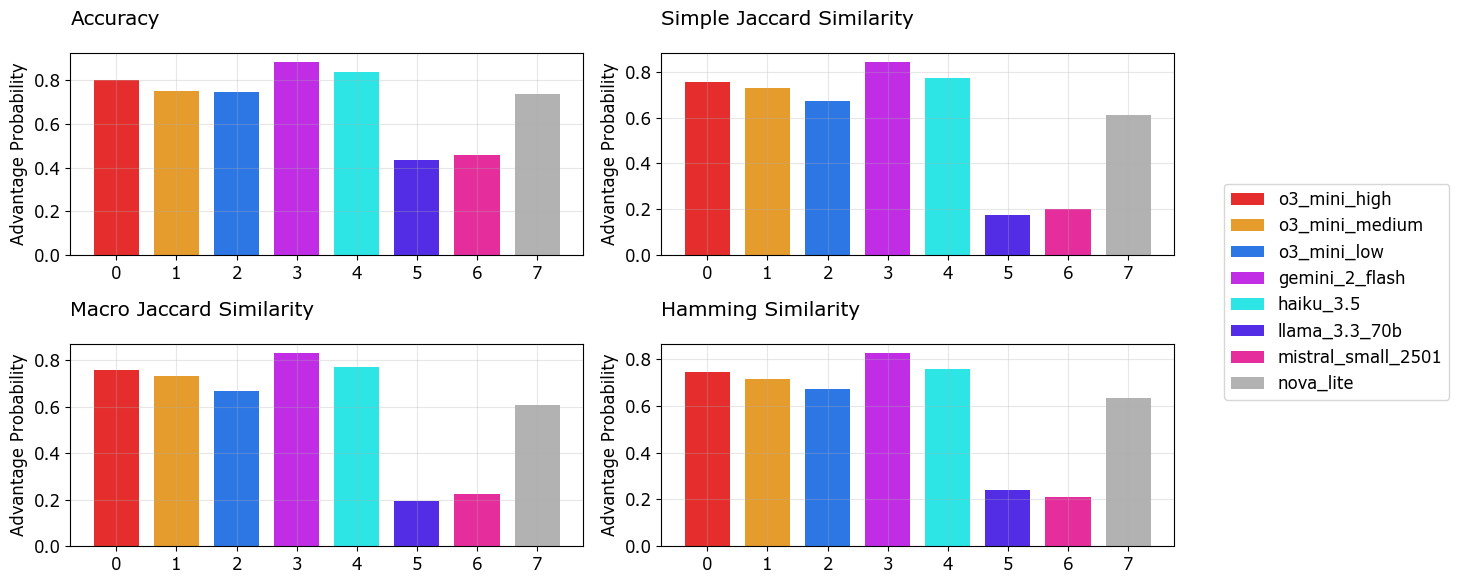

In [11]:
fig = plot_ap(results, LLM_NAMES)
save_plot(fig, f"./llm_advantage_probabilities.png")

### Analyse: Do humans agree with each other?

In [12]:
# Get average metrics for LLM vs human advantage probability
df_ap = pd.DataFrame(ap_results)
df_ap_aggregated_by_llm = (
    df_ap.drop(["metric"], axis=1)
    .groupby("llm")
    .agg(
        lambda x: (
            np.mean([t[0] for t in x]),  # llm ap
            np.mean([t[1] for t in x]),  # human ap
        )
    )
)
display(df_ap_aggregated_by_llm)

,H1,H2,H3,H4,H5,H6
llm,,,,,,
gemini_2_flash,"(0.855, 0.655)","(0.8200000000000001, 0.7349999999999999)","(0.86, 0.66)","(0.855, 0.5950000000000001)","(0.81, 0.55)","(0.86, 0.685)"
haiku_3.5,"(0.7749999999999999, 0.72)","(0.74, 0.73)","(0.8050000000000002, 0.7650000000000001)","(0.79, 0.5950000000000001)","(0.7950000000000002, 0.5800000000000001)","(0.7949999999999999, 0.73)"
llama_3.3_70b,"(0.25, 0.9199999999999999)","(0.275, 0.9149999999999999)","(0.21500000000000002, 0.905)","(0.29500000000000004, 0.8)","(0.29500000000000004, 0.8949999999999999)","(0.24, 0.91)"
mistral_small_2501,"(0.24, 0.895)","(0.29, 0.9049999999999999)","(0.245, 0.885)","(0.305, 0.845)","(0.29, 0.885)","(0.26499999999999996, 0.94)"
nova_lite,"(0.62, 0.77)","(0.63, 0.8150000000000001)","(0.62, 0.8)","(0.665, 0.7150000000000001)","(0.685, 0.67)","(0.66, 0.78)"
o3_mini_high,"(0.75, 0.63)","(0.73, 0.665)","(0.76, 0.71)","(0.79, 0.66)","(0.8049999999999999, 0.585)","(0.75, 0.665)"
o3_mini_low,"(0.645, 0.7050000000000001)","(0.64, 0.71)","(0.6950000000000001, 0.7550000000000001)","(0.7100000000000001, 0.66)","(0.74, 0.635)","(0.7100000000000001, 0.72)"
o3_mini_medium,"(0.675, 0.64)","(0.7150000000000001, 0.685)","(0.73, 0.7000000000000001)","(0.78, 0.635)","(0.7549999999999999, 0.595)","(0.7349999999999999, 0.7050000000000001)"


Saved plot to ./human_advantage_probabilities.png


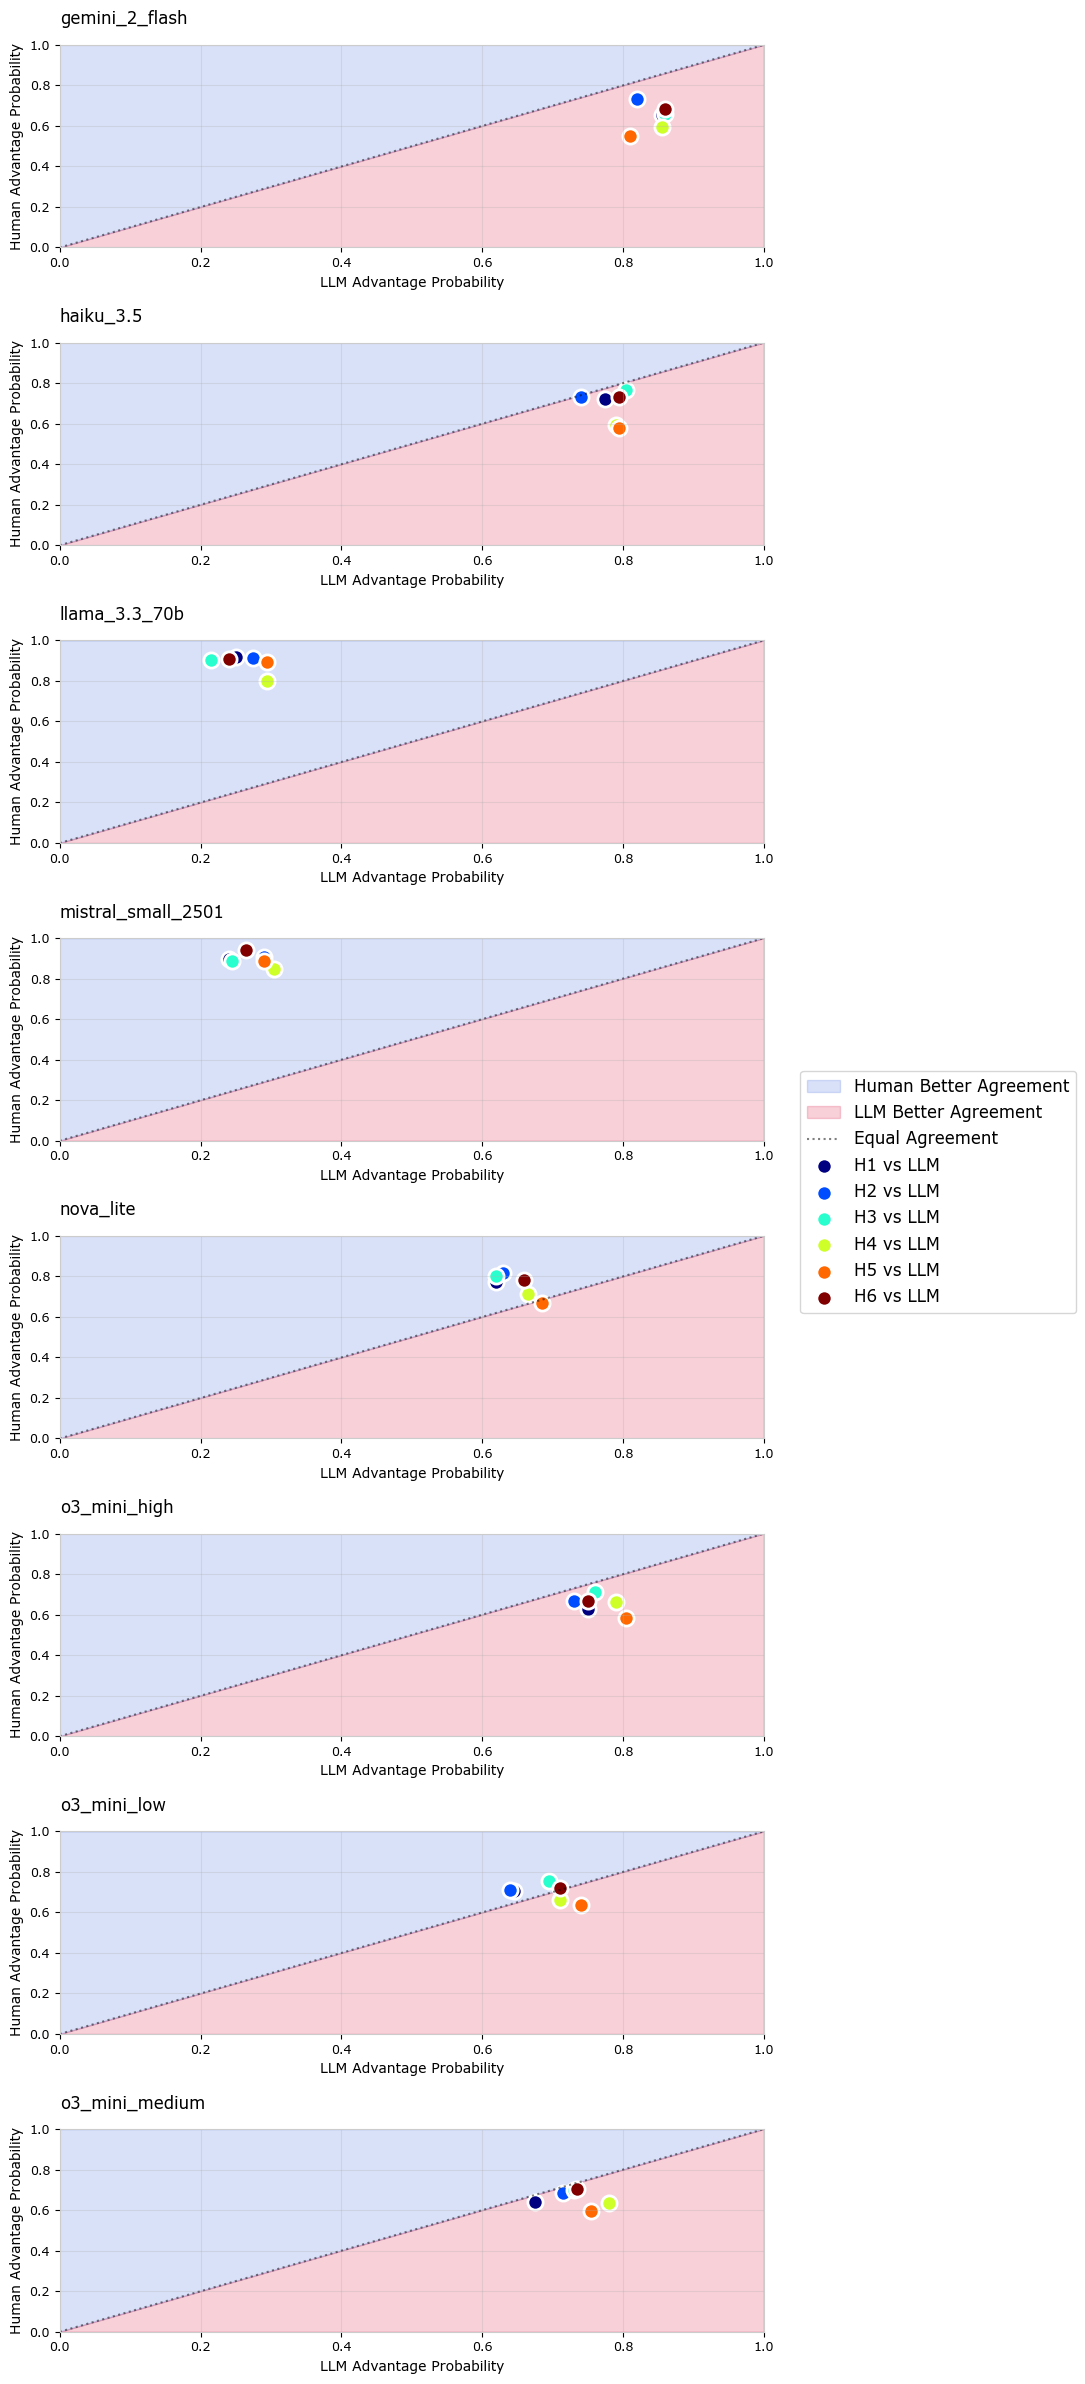

In [13]:
def plot_human_advantage_probabilities(df_ap_aggregated_by_llm):
    """
    Plot a comparison of LLM and human advantage probabilities for each LLM model.
    Each subplot shows, for a given LLM, the advantage probability of the LLM vs. each human annotator.
    """
    num_llm = len(df_ap_aggregated_by_llm.index)
    num_human = len(df_ap_aggregated_by_llm.columns)
    fig, axes = plt.subplots(num_llm, 1, figsize=(8, 3 * num_llm))
    human_colors = plt.cm.jet(np.linspace(0, 1, num_human))

    # Ensure axes is always iterable
    if num_llm == 1:
        axes = [axes]

    for idx, model in enumerate(df_ap_aggregated_by_llm.index):
        ax = axes[idx]

        # Add shaded regions for better/worse/equal performance
        ax.fill_between(
            [0, 1],
            [0, 1],
            [1, 1],
            alpha=0.2,
            color="royalblue",
            label="Human Better Agreement",
        )
        ax.fill_between(
            [0, 1],
            [0, 0],
            [0, 1],
            alpha=0.2,
            color="crimson",
            label="LLM Better Agreement",
        )
        ax.plot([0, 1], [0, 1], ":", color="black", alpha=0.5, label="Equal Agreement")

        # Plot each human's point
        for i, human in enumerate(df_ap_aggregated_by_llm.columns):
            if human != "llm":
                llm_adv, human_adv = df_ap_aggregated_by_llm.loc[model, human]
                ax.scatter(
                    llm_adv,
                    human_adv,
                    label=f"{human} vs LLM",
                    color=human_colors[i],
                    s=120,
                    edgecolor="white",
                    linewidth=2,
                )

        ax.set_title(f"{model}", fontsize=12, pad=15, loc="left")
        ax.set_xlabel("LLM Advantage Probability", fontsize=10)
        ax.set_ylabel("Human Advantage Probability", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.tick_params(axis="both", which="major", labelsize=9)
        for spine in ax.spines.values():
            spine.set_edgecolor("#cccccc")

    # Add a single legend for all plots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    return fig


# Usage example:
fig = plot_human_advantage_probabilities(df_ap_aggregated_by_llm)
save_plot(fig, f"./human_advantage_probabilities.png")
plt.show()

### Analyse: Compare results to Cohen's kappa

In [14]:
from sklearn.metrics import cohen_kappa_score


def get_flattened_labels(annotations, annotator, ids):
    # Returns a flat list of all labels for a given annotator and set of ids.
    # So the comparison is stricter at the category-category level. Binary safe/unsafe is an option but too lenient for 50 samples.
    return [label for id_ in ids for label in annotations[annotator][id_]]


def compute_kappa(annotations1, annotator1, annotations2, annotator2):
    # Find common ids
    common_ids = set(annotations1[annotator1].keys()) & set(
        annotations2[annotator2].keys()
    )
    if not common_ids:
        raise ValueError("No common ids between annotators.")
    # Flatten labels
    labels1 = get_flattened_labels(annotations1, annotator1, common_ids)
    labels2 = get_flattened_labels(annotations2, annotator2, common_ids)
    # Check lengths
    assert len(labels1) == len(labels2), "Label lists must be the same length."
    # Calculate kappa
    return cohen_kappa_score(labels1, labels2)


def pairwise_kappa_table(annotations1, annotations2):
    # Combine all annotators and their sources
    names1 = list(annotations1.keys())
    names2 = list(annotations2.keys())
    # Prepare DataFrame
    kappa_matrix = pd.DataFrame(index=names1, columns=names2)
    # Fill DataFrame
    for i, name1 in enumerate(names1):
        for j, name2 in enumerate(names2):
            kappa = compute_kappa(annotations1, name1, annotations2, name2)
            kappa_matrix.iloc[i, j] = round(kappa, 3) if kappa is not None else None
    return kappa_matrix

In [15]:
# LLM-Human
llm_human_kappa_df = pairwise_kappa_table(llm_annotations, human_annotations)

llm_human_kappa_df["avg"] = llm_human_kappa_df.mean(axis=1)
display(llm_human_kappa_df.sort_values(by="avg", ascending=False))

,H1,H2,H3,H4,H5,H6,avg
gemini_2_flash,0.701,0.666,0.745,0.711,0.709,0.779,0.7185
o3_mini_high,0.654,0.583,0.758,0.735,0.708,0.707,0.690833
o3_mini_medium,0.662,0.589,0.757,0.71,0.673,0.73,0.686833
haiku_3.5,0.612,0.63,0.782,0.67,0.623,0.753,0.678333
o3_mini_low,0.604,0.582,0.714,0.669,0.658,0.701,0.654667
nova_lite,0.52,0.583,0.633,0.606,0.513,0.615,0.578333
mistral_small_2501,0.282,0.265,0.298,0.338,0.362,0.395,0.323333
llama_3.3_70b,0.264,0.251,0.219,0.186,0.224,0.28,0.237333


In [16]:
# Human-Human
human_human_kappa_df = pairwise_kappa_table(human_annotations, human_annotations)
np.fill_diagonal(human_human_kappa_df.values, np.nan)

human_human_kappa_df["avg"] = human_human_kappa_df.mean(axis=1)
display(human_human_kappa_df)

,H1,H2,H3,H4,H5,H6,avg
H1,NaN,0.641,0.644,0.642,0.597,0.638,0.6324
H2,0.641,NaN,0.692,0.581,0.664,0.629,0.6414
H3,0.644,0.692,NaN,0.636,0.603,0.695,0.654
H4,0.642,0.581,0.636,NaN,0.692,0.64,0.6382
H5,0.597,0.664,0.603,0.692,NaN,0.63,0.6372
H6,0.638,0.629,0.695,0.64,0.63,NaN,0.6464


Saved plot to ./llm_human_kappa.png


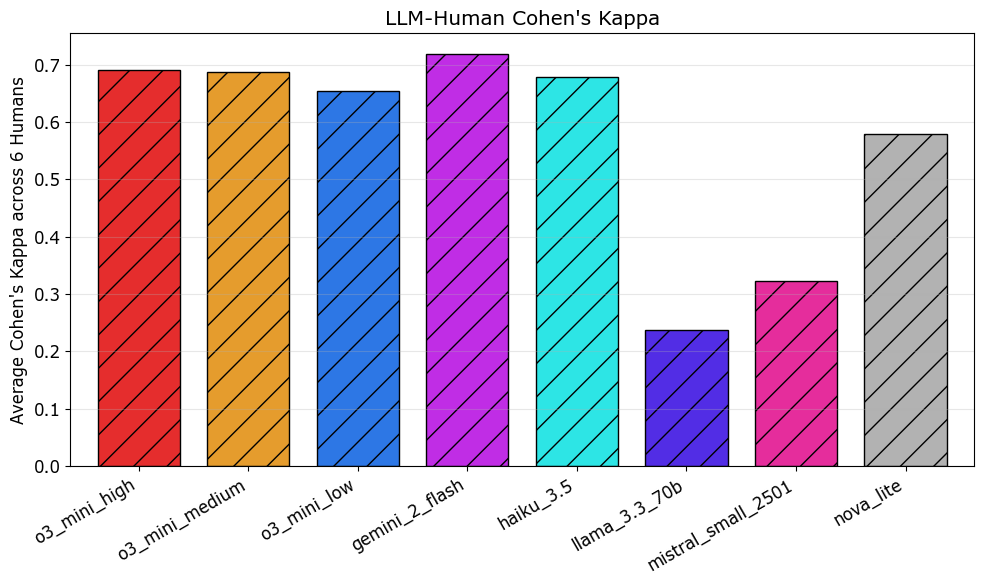

In [17]:
def plot_kappa_bar(kappa_df, title):
    """
    Plot a bar chart of the average Cohen's kappa for each model.
    """
    models = kappa_df.index.tolist()
    base_colors = generate_colors(len(models))

    ax = llm_human_kappa_df["avg"].plot.bar(
        figsize=(10, 6), color=base_colors, width=0.75, edgecolor="k", hatch="/"
    )

    ax.set_ylabel("Average Cohen's Kappa across 6 Humans")
    ax.set_xticklabels(models, rotation=30, ha="right")
    ax.grid(axis="y", alpha=0.3)
    plt.title(title)
    plt.tight_layout()

    return plt.gcf()


fig = plot_kappa_bar(llm_human_kappa_df, "LLM-Human Cohen's Kappa")
save_plot(fig, f"./llm_human_kappa.png")
plt.show()